# Extract spectral power features

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets
from tqdm.notebook import tqdm, trange
import os
from datetime import datetime
import numpy as np

import aopy
from aopy.data import db
from aopy.preproc.quality import detect_bad_trials
from aopy.data import get_ts_data_segment, extract_lfp_features, get_extracted_features, get_decoded_states
from aopy.data import tabulate_ts_segments, tabulate_lfp_features, tabulate_feature_data
from aopy.preproc import get_data_segment

/home/aolab/miniconda3/envs/leo-analysis/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(
/home/aolab/miniconda3/envs/leo-analysis/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Tabulate behavior trials

In [2]:
preproc_dir = '/data/preprocessed'
te_id = 17269
entries = db.lookup_sessions(id=te_id)
decoder = entries[0].get_decoder(decoder_dir='/storage/bmi')

subjects, te_ids, dates = db.list_entry_details(entries)
df = aopy.data.tabulate_behavior_data_center_out(preproc_dir, subjects, te_ids, dates)
display(df[:5])

  0%|          | 0/1 [00:00<?, ?it/s]

,subject,te_id,date,event_codes,event_times,reward,penalty,target_idx,target_location,prev_trial_end_time,...,hold_start_time,hold_completed,delay_start_time,delay_completed,go_cue_time,reach_completed,reach_end_time,reward_start_time,penalty_start_time,penalty_event
0,affi,17269,2024-05-03,"[16, 65, 239]","[5.84544, 21.85648, 22.86792]",False,True,0,"[0.0, 0.0, 0.0]",0.00000,...,NaN,False,NaN,False,NaN,False,NaN,NaN,21.85648,65.0
1,affi,17269,2024-05-03,"[16, 80, 18, 32, 82, 48, 239]","[22.88028, 25.82664, 25.84236, 25.85876, 31.81...",True,False,2,"[4.9497, 4.9497, 0.0]",22.86792,...,25.82664,True,25.84236,True,25.85876,True,31.81748,31.86540,NaN,NaN
2,affi,17269,2024-05-03,"[16, 80, 24, 32, 88, 48, 239]","[34.48108, 42.39212, 42.4078, 42.42248, 44.529...",True,False,8,"[-4.9497, 4.9497, 0.0]",32.47432,...,42.39212,True,42.40780,True,42.42248,True,44.52956,44.57456,NaN,NaN
3,affi,17269,2024-05-03,"[16, 80, 23, 32, 65, 239]","[47.19256, 47.9506, 47.96468, 47.98, 64.00304,...",False,True,7,"[-7.0, -0.0, 0.0]",45.18548,...,47.95060,True,47.96468,True,47.98000,False,NaN,NaN,64.00304,65.0
4,affi,17269,2024-05-03,"[16, 80, 23, 32, 87, 48, 239]","[65.02172, 68.63364, 68.65004, 68.6668, 74.456...",True,False,7,"[-7.0, -0.0, 0.0]",65.00344,...,68.63364,True,68.65004,True,68.66680,True,74.45600,74.50112,NaN,NaN


In [3]:
# Subselect the first 3 rewarded segments
df_sub = df[df['reward']][:3].reset_index()
subjects = df_sub['subject']
te_ids = df_sub['te_id']
dates = df_sub['date']
start_times = df_sub['go_cue_time'].to_numpy()
end_times = df_sub['reach_end_time'].to_numpy()

In [4]:
print(start_times, end_times)

[25.85876 42.42248 68.6668 ] [31.81748 44.52956 74.456  ]


In [5]:
print(decoder.channels)

[ 55  58  60  64  91  97 104 113 211 217 223 227 247 250 252 256]


## Load neural data

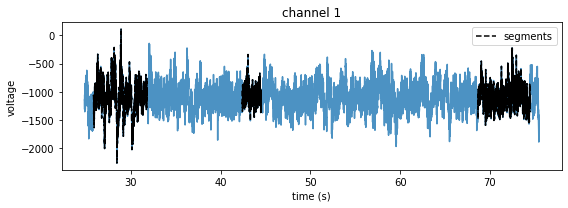

In [6]:
# Plot some neural data from those segments
lfp_segments, samplerate = tabulate_ts_segments(
    preproc_dir, subjects, te_ids, dates, start_times, end_times, channels=decoder.channels-1)

plt.figure(figsize=(8,3))
for idx in range(len(start_times)):
    time = np.arange(len(lfp_segments[idx]))/samplerate + start_times[idx]
    plt.plot(time, lfp_segments[idx][:,1], 'k--', zorder=10)

# Add legends
plt.plot([], [], 'k--', label='segments')
plt.legend()

# Load the full lfp data for comparison
subject = subjects[0]
te_id = te_ids[0]
date = dates[0]

start_time = start_times[0]-1
end_time = end_times[2]+1

lfp_data, samplerate = get_ts_data_segment(
    preproc_dir, subject, te_id, date, start_time, end_time, channels=decoder.channels-1)
time = np.arange(len(lfp_data))/samplerate + start_time

plt.plot(time, lfp_data[:,1], alpha=0.8, label='offline')
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.title('channel 1')

plt.tight_layout()

## Load features using an existing decoder

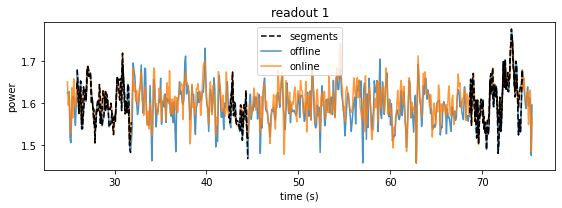

In [7]:
# Plot the feature segments
features_offline, samplerate_offline = tabulate_lfp_features(
    preproc_dir, subjects, te_ids, dates, start_times, end_times, decoder)
features_online, samplerate_online = tabulate_feature_data(
    preproc_dir, subjects, te_ids, dates, start_times, end_times, decoder)

plt.figure(figsize=(8,3))
for idx in range(len(start_times)):
    time_offline = np.arange(len(features_offline[idx]))/samplerate_offline + start_times[idx]
    time_online = np.arange(len(features_online[idx]))/samplerate_online + start_times[idx]

    plt.plot(time_offline, features_offline[idx][:,1], 'k--', zorder=10)
    plt.plot(time_online, features_online[idx][:,1], 'k--', zorder=10)

# Add legends
plt.plot([], [], 'k--', label='segments')


# Load the full features data for comparison
subject = subjects[0]
te_id = te_ids[0]
date = dates[0]

start_time = start_times[0]-1
end_time = end_times[2]+1

features_offline, samplerate_offline = extract_lfp_features(
    preproc_dir, subject, te_id, date, decoder, 
    start_time=start_time, end_time=end_time)
features_online, samplerate_online = get_extracted_features(
    preproc_dir, subject, te_id, date, decoder,
    start_time=start_time, end_time=end_time)
time_offline = np.arange(len(features_offline))/samplerate_offline + start_time
time_online = np.arange(len(features_online))/samplerate_online + start_time

plt.plot(time_offline, features_offline[:,1], alpha=0.8, label='offline')
plt.plot(time_online, features_online[:,1], alpha=0.8, label='online')
plt.xlabel('time (s)')
plt.ylabel('power')
plt.title('readout 1')
plt.legend()

plt.tight_layout()

Note that there is some latency between the offline recorded neural data and the online recorded features. 

Thus the `online` and `offline` features are slightly different. We try to compensate for this by adding latency to the offline recorded data, as illustrated below. The default latency is 20 ms. Best results using the raw broadband data with no preprocessing (i.e. low-pass filtering) yet applied.

17269
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25
Downsampling by a factor of 25


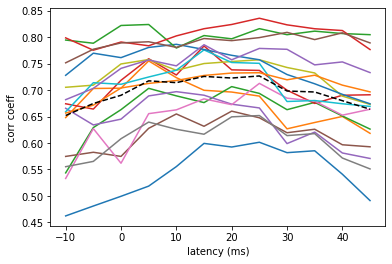

In [8]:
def sweep_latency(e, start_time=10., end_time=20., min_latency=-0.01, max_latency=0.05, step=0.005):
    # Test that extracted features from bci file match the computed features
    subject = e.subject
    te_id = e.id
    date = e.date
    
    decoder = e.get_decoder(decoder_dir='/storage/bmi')


    features_online, online_samplerate = get_extracted_features(preproc_dir, subject, te_id, date, 
                                                                         start_time=start_time, end_time=end_time, decoder=decoder)
    
    latencies = np.arange(min_latency, max_latency, step)
    corrs = []
    for latency in latencies:
        features_offline, offline_samplerate = extract_lfp_features('/media/moor-data/preprocessed', subject, te_id, date, 
                                                                 decoder, start_time=start_time, end_time=end_time, 
                                                                 datatype='broadband', latency=latency)
        ch_corr = []
        for ch in range(features_offline.shape[1]):
            corr = np.corrcoef(features_offline[:,ch], features_online[:,ch,0])
            ch_corr.append(corr[0,1])
        corrs.append(ch_corr)
    
    plt.figure()
    plt.plot(latencies*1000, corrs)
    plt.plot(latencies*1000, np.mean(corrs, axis=1), 'k--')
    plt.xlabel('latency (ms)')
    plt.ylabel('corr coeff')

bci_entries = db.lookup_bmi_sessions(subject='affi', date=('2024-05-03', '2024-05-04'))
print(bci_entries[1].id)
preproc_dir = '/data/preprocessed'
sweep_latency(bci_entries[1])
        


## Load arbitrary features from timeseries data

(3, 22)
(3, 7)
(3, 22)


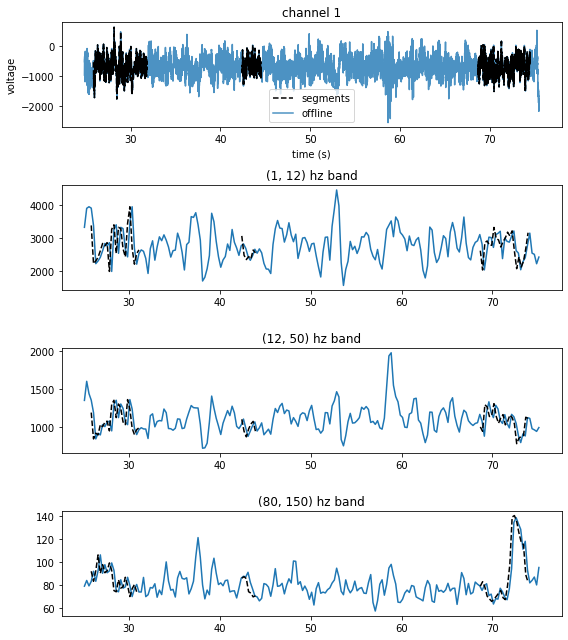

In [9]:
# Fetch some neural data
lfp_segments, samplerate = tabulate_ts_segments(
    preproc_dir, subjects, te_ids, dates, start_times, end_times, channels=[1])

# Extract multiple power bands
bands = [(1,12), (12,50), (80, 150)]
n, p, k = aopy.precondition.convert_taper_parameters(0.5, 25)
step = n/2
fk = 200
features = []
for segment in lfp_segments:
    time, feats = aopy.analysis.get_bandpower_feats(segment, samplerate, bands, 
                                                               n=n, p=p, k=k, step=step, fk=fk)
    print(feats.shape)
    features.append(feats)

# Plot
plt.figure(figsize=(8,9))
plt.subplot(4,1,1)
for idx in range(len(start_times)):
    time = np.arange(len(lfp_segments[idx]))/samplerate + start_times[idx]
    plt.plot(time, lfp_segments[idx][:,0], 'k--', zorder=10)

# Add legends
plt.plot([], [], 'k--', label='segments')

for band_idx, band in enumerate(bands):
    plt.subplot(4,1,band_idx+2)
    for idx in range(len(start_times)):
        time = np.arange(features[idx].shape[1])*step + start_times[idx]
        plt.plot(time, features[idx][band_idx,:], 'k--', zorder=10)
    plt.title(f"{bands[band_idx]} hz band")

# Load the full lfp data for comparison
subject = subjects[0]
te_id = te_ids[0]
date = dates[0]

start_time = start_times[0]-1
end_time = end_times[2]+1

lfp_data, samplerate = get_ts_data_segment(
    preproc_dir, subject, te_id, date, start_time, end_time, channels=[1])
time = np.arange(len(lfp_data))/samplerate + start_time

time_feats, feats = aopy.analysis.get_bandpower_feats(lfp_data, samplerate, bands, 
                                                           n=n, p=p, k=k, step=step, fk=fk)
time_feats += start_time

plt.subplot(4,1,1)
plt.plot(time, lfp_data[:,0], alpha=0.8, label='offline')
plt.xlabel('time (s)')
plt.ylabel('voltage')
plt.title('channel 1')
plt.legend()

for band_idx, band in enumerate(bands):
    plt.subplot(4,1,band_idx+2)
    plt.plot(time_feats, feats[band_idx,:])


plt.tight_layout()